# A year's worth of properties sold on the NYC real estate market

This dataset is a record of every building or building unit (apartment, etc.) sold in the New York City.

In this project we're going to build a model that predicts the sale value.

In [1]:
import julian
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import cross_validation, metrics
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
%matplotlib inline

/home/najet/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df=pd.read_csv('nyc-rolling-sales.csv', index_col=0)
pd.set_option('display.max_columns',999)

In [3]:
df = df.reset_index(drop=True)

## Data exploration

In [4]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,,10009,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,,10009,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,,10009,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,,10009,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,,10009,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84548 entries, 0 to 84547
Data columns (total 21 columns):
BOROUGH                           84548 non-null int64
NEIGHBORHOOD                      84548 non-null object
BUILDING CLASS CATEGORY           84548 non-null object
TAX CLASS AT PRESENT              84548 non-null object
BLOCK                             84548 non-null int64
LOT                               84548 non-null int64
EASE-MENT                         84548 non-null object
BUILDING CLASS AT PRESENT         84548 non-null object
ADDRESS                           84548 non-null object
APARTMENT NUMBER                  84548 non-null object
ZIP CODE                          84548 non-null int64
RESIDENTIAL UNITS                 84548 non-null int64
COMMERCIAL UNITS                  84548 non-null int64
TOTAL UNITS                       84548 non-null int64
LAND SQUARE FEET                  84548 non-null object
GROSS SQUARE FEET                 84548 non-null object
YE

In [6]:
col_obj=[col for col in df.columns.values if df[col].dtype=='object']
for col in col_obj:
    print('*******************************')
    print(col)
    print('nunique: ',df[col].nunique())
    print(df[col].unique())

*******************************
NEIGHBORHOOD
nunique:  254
['ALPHABET CITY' 'CHELSEA' 'CHINATOWN' 'CIVIC CENTER' 'CLINTON'
 'EAST VILLAGE' 'FASHION' 'FINANCIAL' 'FLATIRON' 'GRAMERCY'
 'GREENWICH VILLAGE-CENTRAL' 'GREENWICH VILLAGE-WEST' 'HARLEM-CENTRAL'
 'HARLEM-EAST' 'HARLEM-UPPER' 'HARLEM-WEST' 'INWOOD' 'JAVITS CENTER'
 'KIPS BAY' 'LITTLE ITALY' 'LOWER EAST SIDE' 'MANHATTAN VALLEY'
 'MIDTOWN CBD' 'MIDTOWN EAST' 'MIDTOWN WEST' 'MORNINGSIDE HEIGHTS'
 'MURRAY HILL' 'ROOSEVELT ISLAND' 'SOHO' 'SOUTHBRIDGE' 'TRIBECA'
 'UPPER EAST SIDE (59-79)' 'UPPER EAST SIDE (79-96)'
 'UPPER EAST SIDE (96-110)' 'UPPER WEST SIDE (59-79)'
 'UPPER WEST SIDE (79-96)' 'UPPER WEST SIDE (96-116)'
 'WASHINGTON HEIGHTS LOWER' 'WASHINGTON HEIGHTS UPPER' 'BATHGATE'
 'BAYCHESTER' 'BEDFORD PARK/NORWOOD' 'BELMONT' 'BRONX PARK' 'BRONXDALE'
 'CASTLE HILL/UNIONPORT' 'CITY ISLAND' 'CITY ISLAND-PELHAM STRIP'
 'CO-OP CITY' 'COUNTRY CLUB' 'CROTONA PARK' 'EAST RIVER' 'EAST TREMONT'
 'FIELDSTON' 'FORDHAM' 'HIGHBRIDGE/MORRIS HE

In [7]:
col_obj=[col for col in df.columns.values if df[col].dtype=='int64']
for col in col_obj:
    print('*******************************')
    print(col)
    print('nunique: ',df[col].nunique())
    print(df[col].unique())

*******************************
BOROUGH
nunique:  5
[1 2 3 4 5]
*******************************
BLOCK
nunique:  11566
[ 392  399  402 ... 6918 7074 7092]
*******************************
LOT
nunique:  2627
[  6  26  39 ... 655 423 679]
*******************************
ZIP CODE
nunique:  186
[10009     0 10002 10011 10001 10014 10010 10013 10038 10007 10036 10019
 10018 10003 10005 10004 10006 10016 10012 10026 10030 10031 10027 10035
 10037 10029 10039 10032 10128 10463 10034 10025 10022 10017 10167 10023
 10105 10033 10044 10280 10282 10281 10065 10021 10075 10028 10024 10069
 10040 10457 10458 10451 10456 10469 10466 10475 10468 10467 10460 10473
 10472 10464 10462 10803 10465 10459 10471 10453 10452 10454 10474 10455
 10461 10470 11228 11214 11220 11209 11219 11221 11233 11213 11206 11216
 11205 11238 11226 11204 11234 11217 11201 11218 11232 11230 11235 11212
 11237 11207 11236 11239 11231 11249 11224 11225 11208 11210 11203 11229
 11215 11223 11222 11211 11370 11691 11692 11102 1110

In [8]:
df['SALE PRICE']=pd.to_numeric(df['SALE PRICE'], errors='coerce')
df['LAND SQUARE FEET']=pd.to_numeric(df['LAND SQUARE FEET'], errors='coerce')
df['GROSS SQUARE FEET']=pd.to_numeric(df['GROSS SQUARE FEET'], errors='coerce')

In [9]:
df['SALE DATE']=pd.to_datetime(df['SALE DATE'], errors='coerce')

In [10]:
df['TAX CLASS AT TIME OF SALE'] = df['TAX CLASS AT TIME OF SALE'].astype('category')
df['TAX CLASS AT PRESENT'] = df['TAX CLASS AT PRESENT'].astype('category')

In [11]:
df = df[df['TOTAL UNITS'] == df['COMMERCIAL UNITS'] + df['RESIDENTIAL UNITS']]

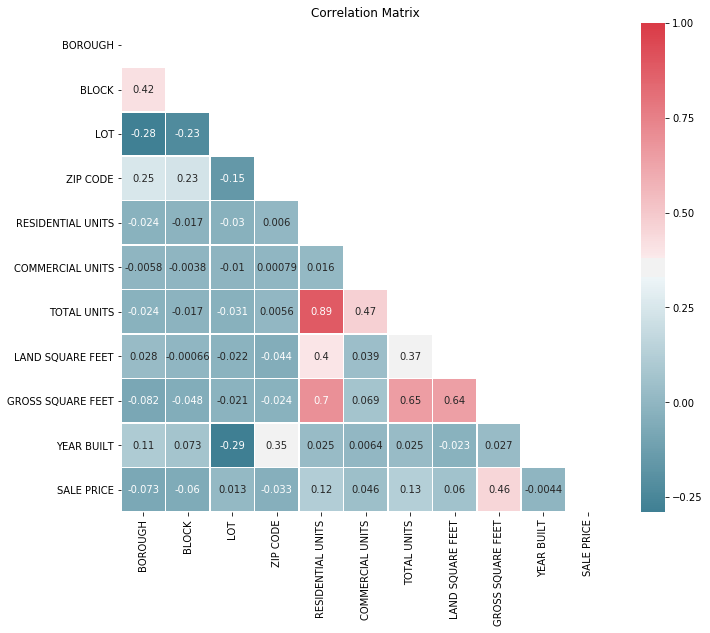

In [12]:


# Correlation Matrix

# Compute the correlation matrix
#d= data[['TOTAL UNITS','GROSS SQUARE FEET','SALE PRICE', 'BUILDING AGE', 'LAND SQUARE FEET', 'RESIDENTIAL UNITS','COMMERCIAL UNITS']]
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, 
            square=True, linewidths=.5, annot=True, cmap=cmap)
plt.yticks(rotation=0)
plt.title('Correlation Matrix')
plt.show()



In [13]:
df['SALE DATE'] = pd.to_datetime(df['SALE DATE'], format='%Y-%m-%d %H:%M:%S')
df['AGE'] = df['SALE DATE'].dt.year - df['YEAR BUILT']

In [14]:
df.drop(['TOTAL UNITS','GROSS SQUARE FEET'], axis=1, inplace=True)

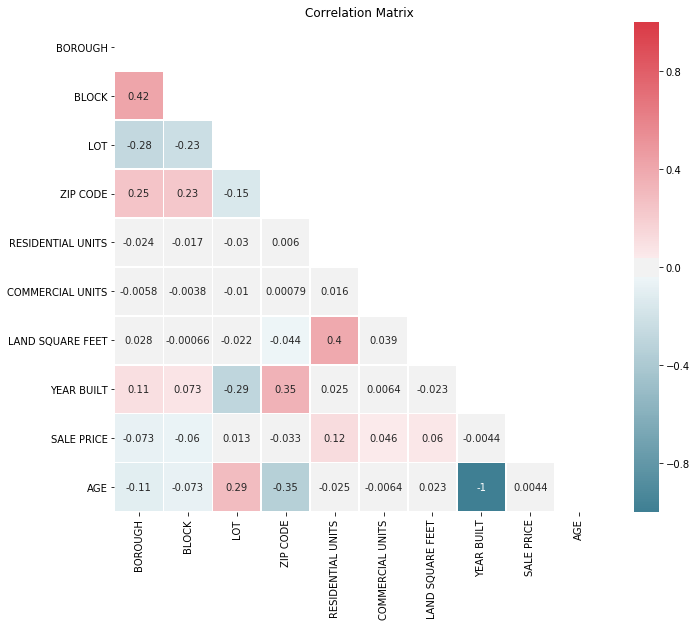

In [15]:
# Correlation Matrix

# Compute the correlation matrix
#d= data[['TOTAL UNITS','GROSS SQUARE FEET','SALE PRICE', 'BUILDING AGE', 'LAND SQUARE FEET', 'RESIDENTIAL UNITS','COMMERCIAL UNITS']]
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, 
            square=True, linewidths=.5, annot=True, cmap=cmap)
plt.yticks(rotation=0)
plt.title('Correlation Matrix')
plt.show()


In [16]:
df.groupby(['ZIP CODE'])['SALE PRICE'].value_counts()

ZIP CODE  SALE PRICE
0         0.0           122
          25000.0         7
          100000.0        7
          1000.0          6
          150000.0        6
          300000.0        6
          350000.0        6
          1200000.0       6
          1.0             5
          250000.0        5
          10.0            4
          100.0           4
          10000.0         4
          20000.0         4
          175000.0        4
          275000.0        4
          400000.0        4
          525000.0        4
          550000.0        4
          850000.0        4
          500.0           3
          5000.0          3
          15000.0         3
          50000.0         3
          60000.0         3
          75000.0         3
          180000.0        3
          225000.0        3
          290000.0        3
          440000.0        3
                       ... 
11694     780000.0        1
          785000.0        1
          793700.0        1
          810000.0        1

## Data Cleaning

In [17]:
df.drop(['EASE-MENT', 'ADDRESS', 'APARTMENT NUMBER', 'BOROUGH', 'BLOCK', 'LOT', 'NEIGHBORHOOD', 'BUILDING CLASS AT PRESENT'], axis=1, inplace=True)

In [18]:
df[['SALE PRICE','LAND SQUARE FEET']]=df[['SALE PRICE', 'LAND SQUARE FEET']].replace(' -  ', np.nan).astype(float)

In [19]:
df[['TAX CLASS AT PRESENT']]=df[['TAX CLASS AT PRESENT']].replace(' ',np.nan)

In [20]:
df[['ZIP CODE', 'YEAR BUILT', 'SALE PRICE', 'LAND SQUARE FEET']]=df[['ZIP CODE', 'YEAR BUILT', 'SALE PRICE', 'LAND SQUARE FEET']].replace(0, np.nan)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81898 entries, 0 to 84547
Data columns (total 12 columns):
BUILDING CLASS CATEGORY           81898 non-null object
TAX CLASS AT PRESENT              81160 non-null category
ZIP CODE                          80916 non-null float64
RESIDENTIAL UNITS                 81898 non-null int64
COMMERCIAL UNITS                  81898 non-null int64
LAND SQUARE FEET                  47938 non-null float64
YEAR BUILT                        75518 non-null float64
TAX CLASS AT TIME OF SALE         81898 non-null category
BUILDING CLASS AT TIME OF SALE    81898 non-null object
SALE PRICE                        58960 non-null float64
SALE DATE                         81898 non-null datetime64[ns]
AGE                               81898 non-null int64
dtypes: category(2), datetime64[ns](1), float64(4), int64(3), object(2)
memory usage: 7.0+ MB


In [22]:
df['YEAR BUILT'].isnull().sum()

6380

In [23]:
df.dropna(subset=['SALE PRICE'],axis=0, inplace=True)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58960 entries, 0 to 84547
Data columns (total 12 columns):
BUILDING CLASS CATEGORY           58960 non-null object
TAX CLASS AT PRESENT              58367 non-null category
ZIP CODE                          58304 non-null float64
RESIDENTIAL UNITS                 58960 non-null int64
COMMERCIAL UNITS                  58960 non-null int64
LAND SQUARE FEET                  30349 non-null float64
YEAR BUILT                        54840 non-null float64
TAX CLASS AT TIME OF SALE         58960 non-null category
BUILDING CLASS AT TIME OF SALE    58960 non-null object
SALE PRICE                        58960 non-null float64
SALE DATE                         58960 non-null datetime64[ns]
AGE                               58960 non-null int64
dtypes: category(2), datetime64[ns](1), float64(4), int64(3), object(2)
memory usage: 5.1+ MB


In [25]:
df['BUILDING CLASS CATEGORY']=df['BUILDING CLASS CATEGORY'].map(lambda x: x[:2])

In [26]:
df['BUILDING CLASS CATEGORY'].unique()

array(['07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17',
       '22', '01', '02', '03', '04', '21', '23', '25', '26', '29', '37',
       '38', '28', '31', '41', '46', '30', '34', '27', '36', '40', '44',
       '32', '43', '33', '05', '06', '35', '39', '47'], dtype=object)

In [27]:
df.isnull().sum()

BUILDING CLASS CATEGORY               0
TAX CLASS AT PRESENT                593
ZIP CODE                            656
RESIDENTIAL UNITS                     0
COMMERCIAL UNITS                      0
LAND SQUARE FEET                  28611
YEAR BUILT                         4120
TAX CLASS AT TIME OF SALE             0
BUILDING CLASS AT TIME OF SALE        0
SALE PRICE                            0
SALE DATE                             0
AGE                                   0
dtype: int64

In [28]:
#(df['TAX CLASS AT PRESENT']!=df['TAX CLASS AT TIME OF SALE']).sum()

In [29]:
df.dropna(subset=['LAND SQUARE FEET'],axis=0, inplace=True)

In [30]:
df.isnull().sum()

BUILDING CLASS CATEGORY             0
TAX CLASS AT PRESENT                0
ZIP CODE                          300
RESIDENTIAL UNITS                   0
COMMERCIAL UNITS                    0
LAND SQUARE FEET                    0
YEAR BUILT                        818
TAX CLASS AT TIME OF SALE           0
BUILDING CLASS AT TIME OF SALE      0
SALE PRICE                          0
SALE DATE                           0
AGE                                 0
dtype: int64

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30349 entries, 0 to 84547
Data columns (total 12 columns):
BUILDING CLASS CATEGORY           30349 non-null object
TAX CLASS AT PRESENT              30349 non-null category
ZIP CODE                          30049 non-null float64
RESIDENTIAL UNITS                 30349 non-null int64
COMMERCIAL UNITS                  30349 non-null int64
LAND SQUARE FEET                  30349 non-null float64
YEAR BUILT                        29531 non-null float64
TAX CLASS AT TIME OF SALE         30349 non-null category
BUILDING CLASS AT TIME OF SALE    30349 non-null object
SALE PRICE                        30349 non-null float64
SALE DATE                         30349 non-null datetime64[ns]
AGE                               30349 non-null int64
dtypes: category(2), datetime64[ns](1), float64(4), int64(3), object(2)
memory usage: 2.6+ MB


In [32]:
df['TAX CLASS AT PRESENT'].unique()

[2A, 2B, 2, 4, 1, 2C, 1B]
Categories (7, object): [2A, 2B, 2, 4, 1, 2C, 1B]

In [33]:
df['TAX CLASS AT PRESENT']=df[df['TAX CLASS AT PRESENT'].notnull()]['TAX CLASS AT PRESENT'].map(lambda x: x[0])

In [34]:
df['TAX CLASS AT PRESENT'].unique()

array(['2', '4', '1'], dtype=object)

In [35]:
(df['TAX CLASS AT PRESENT']!=df['TAX CLASS AT TIME OF SALE']).sum()

30349

In [36]:
#df['SALE DATE'] = pd.to_datetime(df['SALE DATE'], format='%Y-%m-%d %H:%M:%S')
#df['AGE'] = df['SALE DATE'].dt.year - df['YEAR BUILT']

In [37]:
df.drop('YEAR BUILT', axis=1, inplace=True)

In [38]:
df.dropna(subset=['ZIP CODE', 'AGE'],axis=0, inplace=True)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30049 entries, 0 to 84547
Data columns (total 11 columns):
BUILDING CLASS CATEGORY           30049 non-null object
TAX CLASS AT PRESENT              30049 non-null object
ZIP CODE                          30049 non-null float64
RESIDENTIAL UNITS                 30049 non-null int64
COMMERCIAL UNITS                  30049 non-null int64
LAND SQUARE FEET                  30049 non-null float64
TAX CLASS AT TIME OF SALE         30049 non-null category
BUILDING CLASS AT TIME OF SALE    30049 non-null object
SALE PRICE                        30049 non-null float64
SALE DATE                         30049 non-null datetime64[ns]
AGE                               30049 non-null int64
dtypes: category(1), datetime64[ns](1), float64(3), int64(3), object(3)
memory usage: 2.6+ MB


In [40]:
df.isnull().sum()

BUILDING CLASS CATEGORY           0
TAX CLASS AT PRESENT              0
ZIP CODE                          0
RESIDENTIAL UNITS                 0
COMMERCIAL UNITS                  0
LAND SQUARE FEET                  0
TAX CLASS AT TIME OF SALE         0
BUILDING CLASS AT TIME OF SALE    0
SALE PRICE                        0
SALE DATE                         0
AGE                               0
dtype: int64

In [41]:
df.duplicated().sum()

219

In [42]:
df=df.drop_duplicates()

In [43]:
df['YEAR']=(df['SALE DATE'].dt.year).astype('object')

In [44]:
df['YEAR'].unique()

array([2017, 2016], dtype=object)

In [45]:
df['SALE JD']=df['SALE DATE'].map(lambda x:julian.to_jd(x, fmt='jd'))

In [46]:
df['ZIP CODE']=df['ZIP CODE'].astype(int)

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29830 entries, 0 to 84547
Data columns (total 13 columns):
BUILDING CLASS CATEGORY           29830 non-null object
TAX CLASS AT PRESENT              29830 non-null object
ZIP CODE                          29830 non-null int64
RESIDENTIAL UNITS                 29830 non-null int64
COMMERCIAL UNITS                  29830 non-null int64
LAND SQUARE FEET                  29830 non-null float64
TAX CLASS AT TIME OF SALE         29830 non-null category
BUILDING CLASS AT TIME OF SALE    29830 non-null object
SALE PRICE                        29830 non-null float64
SALE DATE                         29830 non-null datetime64[ns]
AGE                               29830 non-null int64
YEAR                              29830 non-null object
SALE JD                           29830 non-null float64
dtypes: category(1), datetime64[ns](1), float64(3), int64(4), object(4)
memory usage: 3.0+ MB


In [48]:
var_to_encode=['BUILDING CLASS CATEGORY', 'TAX CLASS AT PRESENT', 'ZIP CODE', 'TAX CLASS AT TIME OF SALE','BUILDING CLASS AT TIME OF SALE','YEAR']
df = pd.get_dummies(df, columns=var_to_encode, drop_first=True)

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29830 entries, 0 to 84547
Columns: 352 entries, RESIDENTIAL UNITS to YEAR_2017
dtypes: datetime64[ns](1), float64(3), int64(3), uint8(345)
memory usage: 11.6 MB


/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


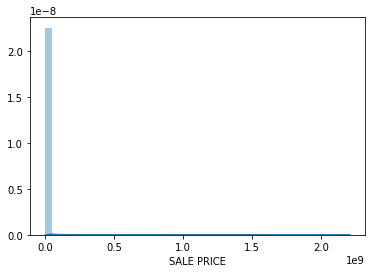

In [50]:
sns.distplot(df['SALE PRICE'])

In [51]:
#data = data[(data['SALE PRICE'] > 100000) & (data['SALE PRICE'] < 5000000)]
df=df[(df['SALE PRICE'] > 100000) & (df['SALE PRICE'] < 5000000)]

In [52]:
df.shape[0]

27225

## Scaling

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


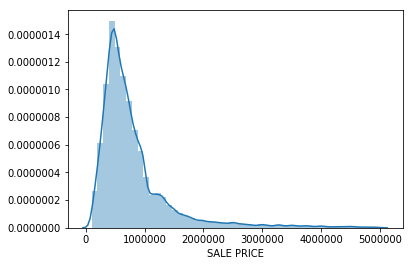

In [53]:
sns.distplot(df['SALE PRICE'])

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


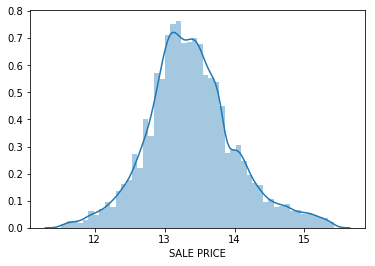

In [54]:
sns.distplot(np.log(df['SALE PRICE']))

In [55]:
df['SALE PRICE']=np.log(df['SALE PRICE'])

In [56]:
cols=[col for col in df.columns.values if col!='SALE DATE']
scaler=StandardScaler()
#df[cols]=scaler.fit_transform(df[cols])

In [57]:
corr=pd.DataFrame(np.corrcoef(df[cols].values.T), cols, cols)
corr

/home/najet/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/najet/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


,RESIDENTIAL UNITS,COMMERCIAL UNITS,LAND SQUARE FEET,SALE PRICE,AGE,SALE JD,BUILDING CLASS CATEGORY_02,BUILDING CLASS CATEGORY_03,BUILDING CLASS CATEGORY_05,BUILDING CLASS CATEGORY_06,BUILDING CLASS CATEGORY_07,BUILDING CLASS CATEGORY_08,BUILDING CLASS CATEGORY_09,BUILDING CLASS CATEGORY_10,BUILDING CLASS CATEGORY_11,BUILDING CLASS CATEGORY_14,BUILDING CLASS CATEGORY_21,BUILDING CLASS CATEGORY_22,BUILDING CLASS CATEGORY_23,BUILDING CLASS CATEGORY_25,BUILDING CLASS CATEGORY_26,BUILDING CLASS CATEGORY_27,BUILDING CLASS CATEGORY_29,BUILDING CLASS CATEGORY_30,BUILDING CLASS CATEGORY_31,BUILDING CLASS CATEGORY_32,BUILDING CLASS CATEGORY_33,BUILDING CLASS CATEGORY_34,BUILDING CLASS CATEGORY_35,BUILDING CLASS CATEGORY_36,BUILDING CLASS CATEGORY_37,BUILDING CLASS CATEGORY_38,BUILDING CLASS CATEGORY_40,BUILDING CLASS CATEGORY_41,TAX CLASS AT PRESENT_2,TAX CLASS AT PRESENT_4,ZIP CODE_10002,ZIP CODE_10003,ZIP CODE_10004,ZIP CODE_10005,ZIP CODE_10006,ZIP CODE_10007,ZIP CODE_10009,ZIP CODE_10010,ZIP CODE_10011,ZIP CODE_10012,ZIP CODE_10013,ZIP CODE_10014,ZIP CODE_10016,ZIP CODE_10017,ZIP CODE_10018,ZIP CODE_10019,ZIP CODE_10021,ZIP CODE_10022,ZIP CODE_10023,ZIP CODE_10024,ZIP CODE_10025,ZIP CODE_10026,ZIP CODE_10027,ZIP CODE_10028,ZIP CODE_10029,ZIP CODE_10030,ZIP CODE_10031,ZIP CODE_10032,ZIP CODE_10033,ZIP CODE_10034,ZIP CODE_10035,ZIP CODE_10036,ZIP CODE_10037,ZIP CODE_10038,ZIP CODE_10039,ZIP CODE_10040,ZIP CODE_10044,ZIP CODE_10065,ZIP CODE_10075,ZIP CODE_10105,ZIP CODE_10128,ZIP CODE_10167,ZIP CODE_10301,ZIP CODE_10302,ZIP CODE_10303,ZIP CODE_10304,ZIP CODE_10305,ZIP CODE_10306,ZIP CODE_10307,ZIP CODE_10308,ZIP CODE_10309,ZIP CODE_10310,ZIP CODE_10312,ZIP CODE_10314,ZIP CODE_10451,ZIP CODE_10452,ZIP CODE_10453,ZIP CODE_10454,ZIP CODE_10455,ZIP CODE_10456,ZIP CODE_10457,ZIP CODE_10458,ZIP CODE_10459,ZIP CODE_10460,ZIP CODE_10461,ZIP CODE_10462,ZIP CODE_10463,ZIP CODE_10464,ZIP CODE_10465,ZIP CODE_10466,ZIP CODE_10467,ZIP CODE_10468,ZIP CODE_10469,ZIP CODE_10470,ZIP CODE_10471,ZIP CODE_10472,ZIP CODE_10473,ZIP CODE_10474,ZIP CODE_10475,ZIP CODE_10803,ZIP CODE_11001,ZIP CODE_11004,ZIP CODE_11005,ZIP CODE_11040,ZIP CODE_11101,ZIP CODE_11102,ZIP CODE_11103,ZIP CODE_11104,ZIP CODE_11105,ZIP CODE_11106,ZIP CODE_11201,ZIP CODE_11203,ZIP CODE_11204,ZIP CODE_11205,ZIP CODE_11206,ZIP CODE_11207,ZIP CODE_11208,ZIP CODE_11209,ZIP CODE_11210,ZIP CODE_11211,ZIP CODE_11212,ZIP CODE_11213,ZIP CODE_11214,ZIP CODE_11215,ZIP CODE_11216,ZIP CODE_11217,ZIP CODE_11218,ZIP CODE_11219,ZIP CODE_11220,ZIP CODE_11221,ZIP CODE_11222,ZIP CODE_11223,ZIP CODE_11224,ZIP CODE_11225,ZIP CODE_11226,ZIP CODE_11228,ZIP CODE_11229,ZIP CODE_11230,ZIP CODE_11231,ZIP CODE_11232,ZIP CODE_11233,ZIP CODE_11234,ZIP CODE_11235,ZIP CODE_11236,ZIP CODE_11237,ZIP CODE_11238,ZIP CODE_11239,ZIP CODE_11249,ZIP CODE_11354,ZIP CODE_11355,ZIP CODE_11356,ZIP CODE_11357,ZIP CODE_11358,ZIP CODE_11360,ZIP CODE_11361,ZIP CODE_11362,ZIP CODE_11363,ZIP CODE_11364,ZIP CODE_11365,ZIP CODE_11366,ZIP CODE_11367,ZIP CODE_11368,ZIP CODE_11369,ZIP CODE_11370,ZIP CODE_11372,ZIP CODE_11373,ZIP CODE_11374,ZIP CODE_11375,ZIP CODE_11377,ZIP CODE_11378,ZIP CODE_11379,ZIP CODE_11385,ZIP CODE_11411,ZIP CODE_11412,ZIP CODE_11413,ZIP CODE_11414,ZIP CODE_11415,ZIP CODE_11416,ZIP CODE_11417,ZIP CODE_11418,ZIP CODE_11419,ZIP CODE_11420,ZIP CODE_11421,ZIP CODE_11422,ZIP CODE_11423,ZIP CODE_11426,ZIP CODE_11427,ZIP CODE_11428,ZIP CODE_11429,ZIP CODE_11432,ZIP CODE_11433,ZIP CODE_11434,ZIP CODE_11435,ZIP CODE_11436,ZIP CODE_11691,ZIP CODE_11692,ZIP CODE_11693,ZIP CODE_11694,TAX CLASS AT TIME OF SALE_2,TAX CLASS AT TIME OF SALE_3,TAX CLASS AT TIME OF SALE_4,BUILDING CLASS AT TIME OF SALE_A1,BUILDING CLASS AT TIME OF SALE_A2,BUILDING CLASS AT TIME OF SALE_A3,BUILDING CLASS AT TIME OF SALE_A4,BUILDING CLASS AT TIME OF SALE_A5,BUILDING CLASS AT TIME OF SALE_A6,BUILDING CLASS AT TIME OF SALE_A7,BUILDING CLASS AT TIME OF SALE_A9,BUILDING CLASS AT TIME OF SALE_B1,BUILDING CLASS AT TIME OF SALE_B2,BUILDING CLASS AT TIME OF SA

In [58]:
df.head()

,RESIDENTIAL UNITS,COMMERCIAL UNITS,LAND SQUARE FEET,SALE PRICE,SALE DATE,AGE,SALE JD,BUILDING CLASS CATEGORY_02,BUILDING CLASS CATEGORY_03,BUILDING CLASS CATEGORY_05,BUILDING CLASS CATEGORY_06,BUILDING CLASS CATEGORY_07,BUILDING CLASS CATEGORY_08,BUILDING CLASS CATEGORY_09,BUILDING CLASS CATEGORY_10,BUILDING CLASS CATEGORY_11,BUILDING CLASS CATEGORY_14,BUILDING CLASS CATEGORY_21,BUILDING CLASS CATEGORY_22,BUILDING CLASS CATEGORY_23,BUILDING CLASS CATEGORY_25,BUILDING CLASS CATEGORY_26,BUILDING CLASS CATEGORY_27,BUILDING CLASS CATEGORY_29,BUILDING CLASS CATEGORY_30,BUILDING CLASS CATEGORY_31,BUILDING CLASS CATEGORY_32,BUILDING CLASS CATEGORY_33,BUILDING CLASS CATEGORY_34,BUILDING CLASS CATEGORY_35,BUILDING CLASS CATEGORY_36,BUILDING CLASS CATEGORY_37,BUILDING CLASS CATEGORY_38,BUILDING CLASS CATEGORY_40,BUILDING CLASS CATEGORY_41,TAX CLASS AT PRESENT_2,TAX CLASS AT PRESENT_4,ZIP CODE_10002,ZIP CODE_10003,ZIP CODE_10004,ZIP CODE_10005,ZIP CODE_10006,ZIP CODE_10007,ZIP CODE_10009,ZIP CODE_10010,ZIP CODE_10011,ZIP CODE_10012,ZIP CODE_10013,ZIP CODE_10014,ZIP CODE_10016,ZIP CODE_10017,ZIP CODE_10018,ZIP CODE_10019,ZIP CODE_10021,ZIP CODE_10022,ZIP CODE_10023,ZIP CODE_10024,ZIP CODE_10025,ZIP CODE_10026,ZIP CODE_10027,ZIP CODE_10028,ZIP CODE_10029,ZIP CODE_10030,ZIP CODE_10031,ZIP CODE_10032,ZIP CODE_10033,ZIP CODE_10034,ZIP CODE_10035,ZIP CODE_10036,ZIP CODE_10037,ZIP CODE_10038,ZIP CODE_10039,ZIP CODE_10040,ZIP CODE_10044,ZIP CODE_10065,ZIP CODE_10075,ZIP CODE_10105,ZIP CODE_10128,ZIP CODE_10167,ZIP CODE_10301,ZIP CODE_10302,ZIP CODE_10303,ZIP CODE_10304,ZIP CODE_10305,ZIP CODE_10306,ZIP CODE_10307,ZIP CODE_10308,ZIP CODE_10309,ZIP CODE_10310,ZIP CODE_10312,ZIP CODE_10314,ZIP CODE_10451,ZIP CODE_10452,ZIP CODE_10453,ZIP CODE_10454,ZIP CODE_10455,ZIP CODE_10456,ZIP CODE_10457,ZIP CODE_10458,ZIP CODE_10459,ZIP CODE_10460,ZIP CODE_10461,ZIP CODE_10462,ZIP CODE_10463,ZIP CODE_10464,ZIP CODE_10465,ZIP CODE_10466,ZIP CODE_10467,ZIP CODE_10468,ZIP CODE_10469,ZIP CODE_10470,ZIP CODE_10471,ZIP CODE_10472,ZIP CODE_10473,ZIP CODE_10474,ZIP CODE_10475,ZIP CODE_10803,ZIP CODE_11001,ZIP CODE_11004,ZIP CODE_11005,ZIP CODE_11040,ZIP CODE_11101,ZIP CODE_11102,ZIP CODE_11103,ZIP CODE_11104,ZIP CODE_11105,ZIP CODE_11106,ZIP CODE_11201,ZIP CODE_11203,ZIP CODE_11204,ZIP CODE_11205,ZIP CODE_11206,ZIP CODE_11207,ZIP CODE_11208,ZIP CODE_11209,ZIP CODE_11210,ZIP CODE_11211,ZIP CODE_11212,ZIP CODE_11213,ZIP CODE_11214,ZIP CODE_11215,ZIP CODE_11216,ZIP CODE_11217,ZIP CODE_11218,ZIP CODE_11219,ZIP CODE_11220,ZIP CODE_11221,ZIP CODE_11222,ZIP CODE_11223,ZIP CODE_11224,ZIP CODE_11225,ZIP CODE_11226,ZIP CODE_11228,ZIP CODE_11229,ZIP CODE_11230,ZIP CODE_11231,ZIP CODE_11232,ZIP CODE_11233,ZIP CODE_11234,ZIP CODE_11235,ZIP CODE_11236,ZIP CODE_11237,ZIP CODE_11238,ZIP CODE_11239,ZIP CODE_11249,ZIP CODE_11354,ZIP CODE_11355,ZIP CODE_11356,ZIP CODE_11357,ZIP CODE_11358,ZIP CODE_11360,ZIP CODE_11361,ZIP CODE_11362,ZIP CODE_11363,ZIP CODE_11364,ZIP CODE_11365,ZIP CODE_11366,ZIP CODE_11367,ZIP CODE_11368,ZIP CODE_11369,ZIP CODE_11370,ZIP CODE_11372,ZIP CODE_11373,ZIP CODE_11374,ZIP CODE_11375,ZIP CODE_11377,ZIP CODE_11378,ZIP CODE_11379,ZIP CODE_11385,ZIP CODE_11411,ZIP CODE_11412,ZIP CODE_11413,ZIP CODE_11414,ZIP CODE_11415,ZIP CODE_11416,ZIP CODE_11417,ZIP CODE_11418,ZIP CODE_11419,ZIP CODE_11420,ZIP CODE_11421,ZIP CODE_11422,ZIP CODE_11423,ZIP CODE_11426,ZIP CODE_11427,ZIP CODE_11428,ZIP CODE_11429,ZIP CODE_11432,ZIP CODE_11433,ZIP CODE_11434,ZIP CODE_11435,ZIP CODE_11436,ZIP CODE_11691,ZIP CODE_11692,ZIP CODE_11693,ZIP CODE_11694,TAX CLASS AT TIME OF SALE_2,TAX CLASS AT TIME OF SALE_3,TAX CLASS AT TIME OF SALE_4,BUILDING CLASS AT TIME OF SALE_A1,BUILDING CLASS AT TIME OF SALE_A2,BUILDING CLASS AT TIME OF SALE_A3,BUILDING CLASS AT TIME OF SALE_A4,BUILDING CLASS AT TIME OF SALE_A5,BUILDING CLASS AT TIME OF SALE_A6,BUILDING CLASS AT TIME OF SALE_A7,BUILDING CLASS AT TIME OF SALE_A9,BUILDING CLASS AT TIME OF SALE_B1,BUILDING CLASS AT TIME OF SALE_B2,BUILDING CLASS AT 

## Building Linear Regression Model

In [59]:
X=df[[col for col in df.columns.values if col!='SALE DATE' and col!='SALE PRICE' and col!='YEAR_2017']].values
Y=df['SALE PRICE'].values

In [60]:
X_train, X_test, y_train, y_test=train_test_split(X, Y, test_size=0.3, random_state=26)

In [61]:
model=LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [62]:
predictions=model.predict(X_test)

In [63]:
cv_scores_linreg = cross_val_score(model, X_train, y_train, cv=5)
model.score(X_test, y_test)

0.49493579078233285

In [64]:
print('R² test: ',metrics.r2_score(y_pred=predictions, y_true=y_test)) 
print('R² train: ',model.score(X_train, y_train))

R² test:  0.49493579078233285
R² train:  0.5533218202841139


In [65]:
X=df[[col for col in df.columns.values if col!='SALE DATE' and col!='SALE PRICE' and col!='YEAR_2017']].values
Y=df['SALE PRICE'].values
X= sm.add_constant(X)
X_train, X_test, y_train, y_test=train_test_split(X, Y, test_size=0.3)
results = sm.OLS(y_train, X_train).fit()
predict=results.predict(X_test)
print(results.summary())
print('R² test: ',metrics.r2_score(y_pred=predict, y_true=y_test)) 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     84.16
Date:                Tue, 10 Jul 2018   Prob (F-statistic):               0.00
Time:                        15:04:55   Log-Likelihood:                -10686.
No. Observations:               19057   AIC:                         2.191e+04
Df Residuals:                   18786   BIC:                         2.404e+04
Df Model:                         270                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -602.3397     73.882     -8.153      0.0

/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/home/najet/.local/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/najet/.local/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/najet/.local/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [66]:
predictors=np.array([col for col in df.columns.values if col!='SALE DATE' and col!='SALE PRICE' and col!='YEAR_2017'])
pvalues=results.pvalues
#pvalues[pvalues>0.05]
indexes=np.where(pvalues>0.05)[0]
cols_eliminate=predictors[(indexes-1).tolist()].tolist()
#cols_eliminate

/home/najet/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


In [67]:
X=df[[col for col in df.columns.values if col!='SALE DATE' and col!='SALE PRICE' and col!='YEAR_2017' and col not in cols_eliminate]].values
Y=df['SALE PRICE'].values
X= sm.add_constant(X)
X_train, X_test, y_train, y_test=train_test_split(X, Y, test_size=0.3)
results = sm.OLS(y_train, X_train).fit()
predict=results.predict(X_test)
print(results.summary())
print('R² test: ',metrics.r2_score(y_pred=predict, y_true=y_test)) 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.338
Method:                 Least Squares   F-statistic:                     91.81
Date:                Tue, 10 Jul 2018   Prob (F-statistic):               0.00
Time:                        15:04:57   Log-Likelihood:                -14343.
No. Observations:               19057   AIC:                         2.890e+04
Df Residuals:                   18949   BIC:                         2.975e+04
Df Model:                         107                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -661.9625     88.533     -7.477      0.0

/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/home/najet/.local/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/najet/.local/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/najet/.local/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [68]:
predictors=np.array([col for col in df.columns.values if col!='SALE DATE' and col!='SALE PRICE' and col!='YEAR_2017' and col not in cols_eliminate])
pvalues=results.pvalues
indexes2=np.where(pvalues>0.05)[0]
cols_eliminate2=predictors[(indexes2-1).tolist()].tolist()

/home/najet/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


In [69]:
X=df[[col for col in df.columns.values if col!='SALE DATE' and col!='SALE PRICE' and col!='YEAR_2017' and col not in cols_eliminate and col not in cols_eliminate2]].values
X= sm.add_constant(X)
Y=df['SALE PRICE'].values
X_train, X_test, y_train, y_test=train_test_split(X, Y, test_size=0.3)
results = sm.OLS(y_train, X_train).fit()
predict=results.predict(X_test)
print(results.summary())
print('R² test: ',metrics.r2_score(y_pred=predict, y_true=y_test)) 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     143.5
Date:                Tue, 10 Jul 2018   Prob (F-statistic):               0.00
Time:                        15:04:58   Log-Likelihood:                -14314.
No. Observations:               19057   AIC:                         2.877e+04
Df Residuals:                   18987   BIC:                         2.932e+04
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -750.0606     87.895     -8.534      0.0

/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/home/najet/.local/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/najet/.local/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/najet/.local/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [70]:
predictors=np.array([col for col in df.columns.values if col!='SALE DATE' and col!='YEAR_2017' and col!='SALE PRICE' and col not in cols_eliminate and col not in cols_eliminate2])
pvalues=results.pvalues
indexes3=np.where(pvalues>0.05)[0]
cols_eliminate3=predictors[(indexes3-1).tolist()].tolist()
#cols_eliminate3

/home/najet/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


In [71]:
X=df[[col for col in df.columns.values if col!='SALE DATE' and col!='SALE PRICE' and col!='YEAR_2017' and col not in cols_eliminate and col not in cols_eliminate2 and col not in cols_eliminate3]].values
X= sm.add_constant(X)
Y=df['SALE PRICE'].values
X_train, X_test, y_train, y_test=train_test_split(X, Y, test_size=0.3)
results = sm.OLS(y_train, X_train).fit()
predict=results.predict(X_test)
print(results.summary())
print('R² test: ',metrics.r2_score(y_pred=predict, y_true=y_test)) 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     147.4
Date:                Tue, 10 Jul 2018   Prob (F-statistic):               0.00
Time:                        15:04:59   Log-Likelihood:                -14485.
No. Observations:               19057   AIC:                         2.910e+04
Df Residuals:                   18992   BIC:                         2.961e+04
Df Model:                          64                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -641.8609     89.116     -7.203      0.0

/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/home/najet/.local/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/najet/.local/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/najet/.local/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [72]:
X = df[[col for col in df.columns.values if col!='SALE DATE' and col!='SALE PRICE' and col!='YEAR_2017' and col not in cols_eliminate and col not in cols_eliminate2 and col not in cols_eliminate3]].values
Y = df['SALE PRICE'].values
X_train, X_test, y_train, y_test=train_test_split(X, Y, test_size=0.3)

model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print("LinReg R²:", metrics.r2_score(y_pred=predictions, y_true=y_test))

LinReg R²: 0.3161368450408508


# Ridge Regression

In [73]:
Xx = df[[col for col in df.columns.values if col!='SALE DATE' and col!='YEAR_2017' and col!='SALE PRICE']]
Yy = df['SALE PRICE']

alphas = 10**np.linspace(10,-2,100)*0.5
#Use the cross-validation package to split data into training and test sets
X_train, X_test , y_train, y_test = cross_validation.train_test_split(Xx, Yy, test_size = 0.3)

ridgecv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')
ridgecv.fit(X_train, y_train)
ridge = Ridge(alpha=ridgecv.alpha_)
ridge.fit(X_train, y_train)
pred = ridge.predict(X_test)
print("Lambda: ",ridgecv.alpha_)
#print(pd.Series(ridge.coef_, index = Xx.columns)) # Print coefficients
print("R² test: ", metrics.explained_variance_score(y_pred=pred, y_true=y_test))
print("R² train: ", metrics.explained_variance_score(y_pred=ridge.predict(X_train), y_true=y_train))
print("MSE: ",metrics.mean_squared_error(y_test, pred)) # Calculate the test MSE
ridge_coeff=pd.Series(ridge.coef_, index=Xx.columns)
#print(ridge_coeff)
ridge_coeff.sort_values(ascending=False)

Lambda:  4.055654153948428
R² test:  -1.7875351595409645
R² train:  0.5367099416485901
MSE:  1.1339707107560717


ZIP CODE_11201                       0.985309
ZIP CODE_11217                       0.915497
ZIP CODE_11249                       0.829002
ZIP CODE_11231                       0.801817
ZIP CODE_11215                       0.743762
ZIP CODE_11238                       0.731337
BUILDING CLASS CATEGORY_08           0.690125
ZIP CODE_10037                       0.681646
ZIP CODE_10031                       0.669768
ZIP CODE_10009                       0.667638
ZIP CODE_10025                       0.664523
ZIP CODE_10016                       0.659698
ZIP CODE_11222                       0.652813
ZIP CODE_10035                       0.599961
ZIP CODE_11205                       0.582762
BUILDING CLASS AT TIME OF SALE_A3    0.580974
ZIP CODE_10030                       0.574806
ZIP CODE_10027                       0.529114
TAX CLASS AT TIME OF SALE_4          0.505669
BUILDING CLASS AT TIME OF SALE_D1    0.494013
ZIP CODE_11211                       0.481995
ZIP CODE_11230                    

In [74]:
lasso = Lasso(max_iter=10000)
lassocv = LassoCV(alphas=alphas, max_iter=100000)
lassocv.fit(X_train, y_train)
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)
pred3 = lasso.predict(X_test)
print("Lambda: ",lassocv.alpha_)
#print(pd.Series(lasso.coef_, index = Xx.columns)) # Print coefficients
print("R² test: ", metrics.explained_variance_score(y_pred=pred3, y_true=y_test))
print("R² train: ", metrics.explained_variance_score(y_pred=lasso.predict(X_train), y_true=y_train))
print("MSE: ", metrics.mean_squared_error(y_test,pred3))
lasso_coeff=pd.Series(lasso.coef_, index=Xx.columns)
#print(lasso_coeff)
lasso_coeff.sort_values(ascending=False)

Lambda:  0.005
R² test:  -6.0753092082442715
R² train:  0.19150605494706008
MSE:  2.87861664579441


TAX CLASS AT TIME OF SALE_2          5.214994e-01
TAX CLASS AT TIME OF SALE_4          3.556643e-01
ZIP CODE_11215                       1.813032e-01
BUILDING CLASS CATEGORY_03           1.597015e-01
COMMERCIAL UNITS                     6.306112e-02
BUILDING CLASS AT TIME OF SALE_C1    6.082487e-02
BUILDING CLASS AT TIME OF SALE_A3    5.047132e-02
BUILDING CLASS CATEGORY_07           2.994496e-02
SALE JD                              2.635347e-04
BUILDING CLASS AT TIME OF SALE_C0    2.135975e-06
LAND SQUARE FEET                     9.557987e-07
ZIP CODE_10456                      -0.000000e+00
ZIP CODE_11105                       0.000000e+00
ZIP CODE_11040                       0.000000e+00
ZIP CODE_11101                       0.000000e+00
ZIP CODE_11102                       0.000000e+00
ZIP CODE_11103                       0.000000e+00
ZIP CODE_10455                      -0.000000e+00
ZIP CODE_11104                       0.000000e+00
ZIP CODE_11201                       0.000000e+00
